In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib.patches import Patch

In [55]:
inpath = '/gpfs/soma_fs/scratch/src/boeger/data_roca'
inpath_with_subfolders = True
inpath_pattern = ['L118']

In [78]:
all_files = [os.path.join(root, name) for root, dirs, files in os.walk(inpath) for name in files if 'predicted' in os.path.basename(root) and any(pat in os.path.basename(root) for pat in inpath_pattern)]
fpath = [f for f in all_files if 'predicted.json' in f]

In [26]:
cluster_color = {
    -1: '#dbdbdb',
    0: '#BB0A21',
    1: '#FF680A',
    2: '#ffa047',
    3: '#00665c',
    4: '#008f6b',
    5: '#00b88a',
    6: '#6b1e5a',
    7: '#a24d91',}
cluster_group_man = {
  -1: 'None',
  0: 'pred. feed',
  1: 'pred. bite',
  2: 'pred. search',
  3: 'dwelling',
  4: 'unstable dwelling',
  5: 'dwelling with noise',
  6: 'roaming',
  7: 'fast roaming'}

In [96]:
def ethogram_plotter(d, y, onoff,  smooth, cluster_color, cluster_label, fn, figsize=(20,5), fps=30,xtick_spread=30, d_toplot=['velocity', 'rate'], d_bar_alpha =0.3):
    timeinsec = np.array(range(len(d)))/fps
    
    fig, axs = plt.subplots(len(d_toplot)+1,1, figsize=figsize,constrained_layout=True)
    
    for c in np.unique(y).astype(int):
        axs[0].broken_barh(onoff[c],(0,1),facecolors = cluster_color[c])
    axs[0].set_xticks(range(len(timeinsec))[::xtick_spread*fps])
    axs[0].set_xticklabels(timeinsec[::xtick_spread*fps].astype(int))
    axs[0].set_title(f'Cluster preditcion (smoothed {smooth/fps} sec).')
    axs[0].xaxis.set_minor_locator(plt.MultipleLocator(5*fps))
    for i,c in enumerate(d_toplot):
        for c_ in np.unique(y).astype(int):
            #axs[i+1].broken_barh(onoff[c_],(min(d[c]),max(d[c])),facecolors = cluster_color[c_], alpha=0.6, zorder=0)
            axs[i+1].broken_barh(onoff[c_],(np.nanmin(d[c]),np.nanmax(d[c])-np.nanmin(d[c])),facecolors = cluster_color[c_], alpha=d_bar_alpha, zorder=0)
        axs[i+1].plot(d[c].rolling(30, min_periods=0).mean(),c='k')
        axs[i+1].set_xticks(range(len(timeinsec))[::xtick_spread*fps])
        axs[i+1].set_xticklabels(timeinsec[::xtick_spread*fps].astype(int))
        axs[i+1].set_title(f"{c} (smoothed, 1 sec)")
        axs[i+1].xaxis.set_minor_locator(plt.MultipleLocator(5*fps))
    axs[2].set_xlabel('sec')
    
    plt.legend(handles=[Patch(facecolor=cluster_color[i]) for i in np.unique(y).astype(int)],
          labels=[cluster_label[k] for k in cluster_label if k in np.unique(y)],
          ncol=3, loc='upper left',
          bbox_to_anchor=(0, -0.5))
    fig.suptitle(f'Ethogram of {fn}',fontsize=16)
    return fig

In [28]:
def onoff_dict(arr_raw, labels = range(-1,4), return_duration=False, return_transitions = False, return_all = False, treatasone=True):

    if not isinstance(arr_raw, list):
        arr_raw = [arr_raw]

    arr_onoff = {}
    arr_transi =  []
    arr_onset =  []
    arr_onnext =  []
    arr_dur =  []
    total_dur = 0
    for i,a in enumerate(arr_raw):
        if isinstance(a, pd.Series) or isinstance(a, pd.DataFrame):
            a = a.values
        arr_s = a[1:]
        arr = a[:-1]

        transi = np.append(arr[arr != arr_s], arr[-1])
        onset = (np.concatenate([[0],np.where([arr != arr_s])[1]+1]))
        onnext = (np.append(np.array((onset)[1:]), [len(arr)+1]))
        dur = (onnext)-onset
        arr_transi.append(transi)
        arr_onset.append(onset)
        arr_onnext.append(onnext)
        arr_dur.append(dur)

        if treatasone:
            if i > 0:
                total_dur += arr_onnext[i-1][-1]

        for b in np.unique(a):
            b_idx = np.where(transi == b)
            b_onoff = list(zip(onset[b_idx]+total_dur, dur[b_idx]))
            if b in arr_onoff.keys():
                arr_onoff[b] = arr_onoff[b]+b_onoff
            else:
                arr_onoff[b] = b_onoff
    if treatasone:
        arr_dur = np.concatenate(arr_dur)
        arr_transi = np.concatenate(arr_transi)
        arr_onset = np.concatenate([a+arr_onnext[i-1][-1] if i > 0 else a for i,a in enumerate(arr_onset)])
        arr_onnext = np.concatenate([a+arr_onnext[i-1][-1] if i > 0 else a for i,a in enumerate(arr_onnext)])
        # might hav to work here on further, change how arr_onset and arr_onnext are daved

    if return_all == True:
        return arr_onoff, arr_dur, arr_transi, arr_onset, arr_onnext
    elif return_transitions == True and return_duration == True:
        return arr_onoff, arr_dur, arr_transi
    elif return_duration == True or return_transitions == True:
        if return_duration == True:
            return arr_onoff, arr_dur
        if return_transitions == True:
            return arr_onoff, arr_transi
    else:
        return arr_onoff

In [102]:
f_idx = 25
file = pd.read_json(fpath[f_idx], orient='split')
fn = os.path.basename(fpath[f_idx])

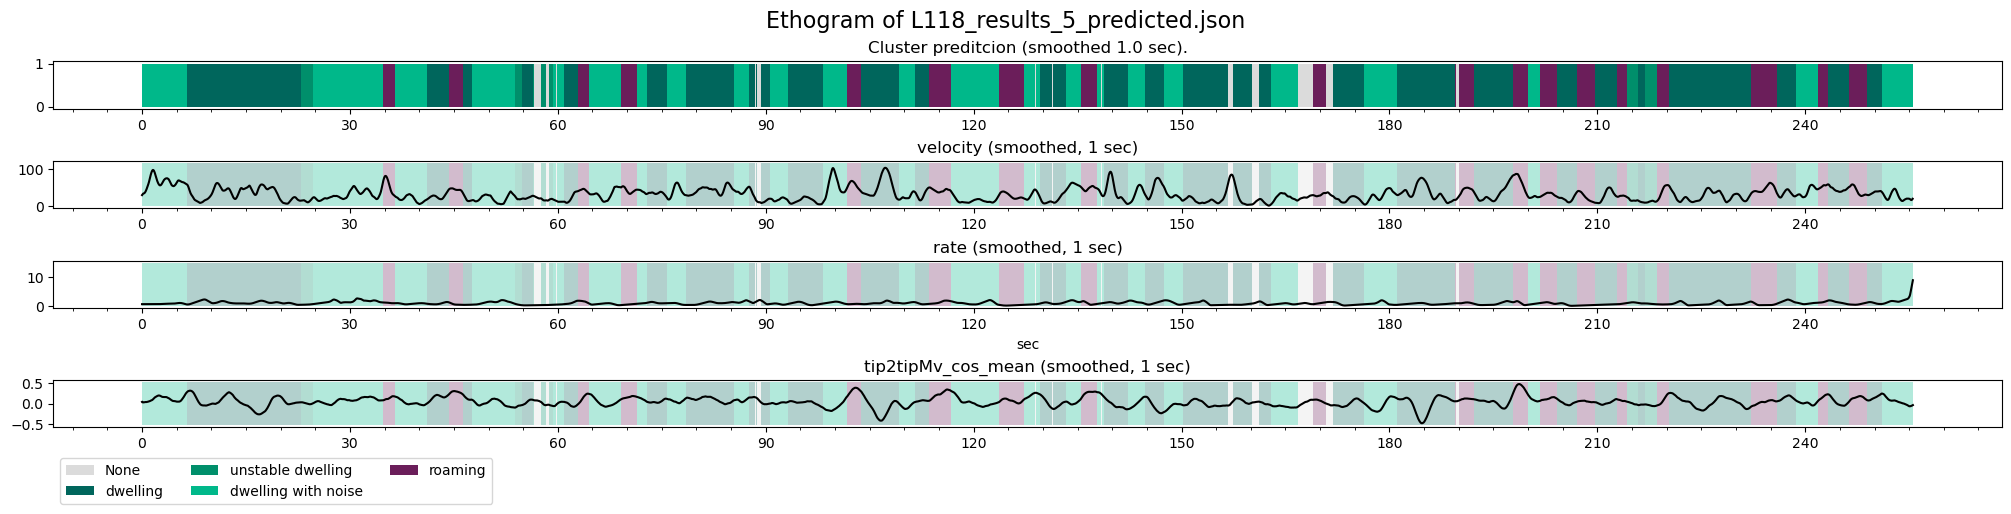

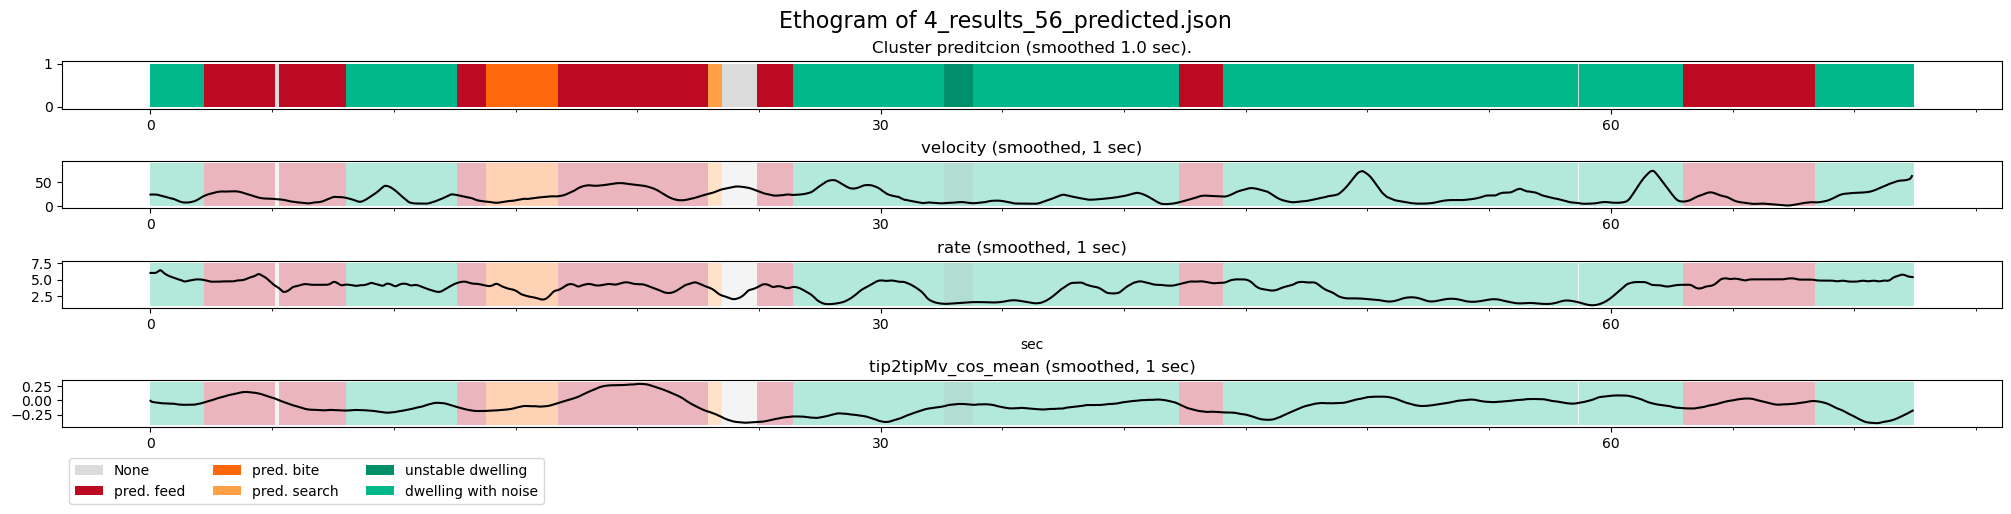

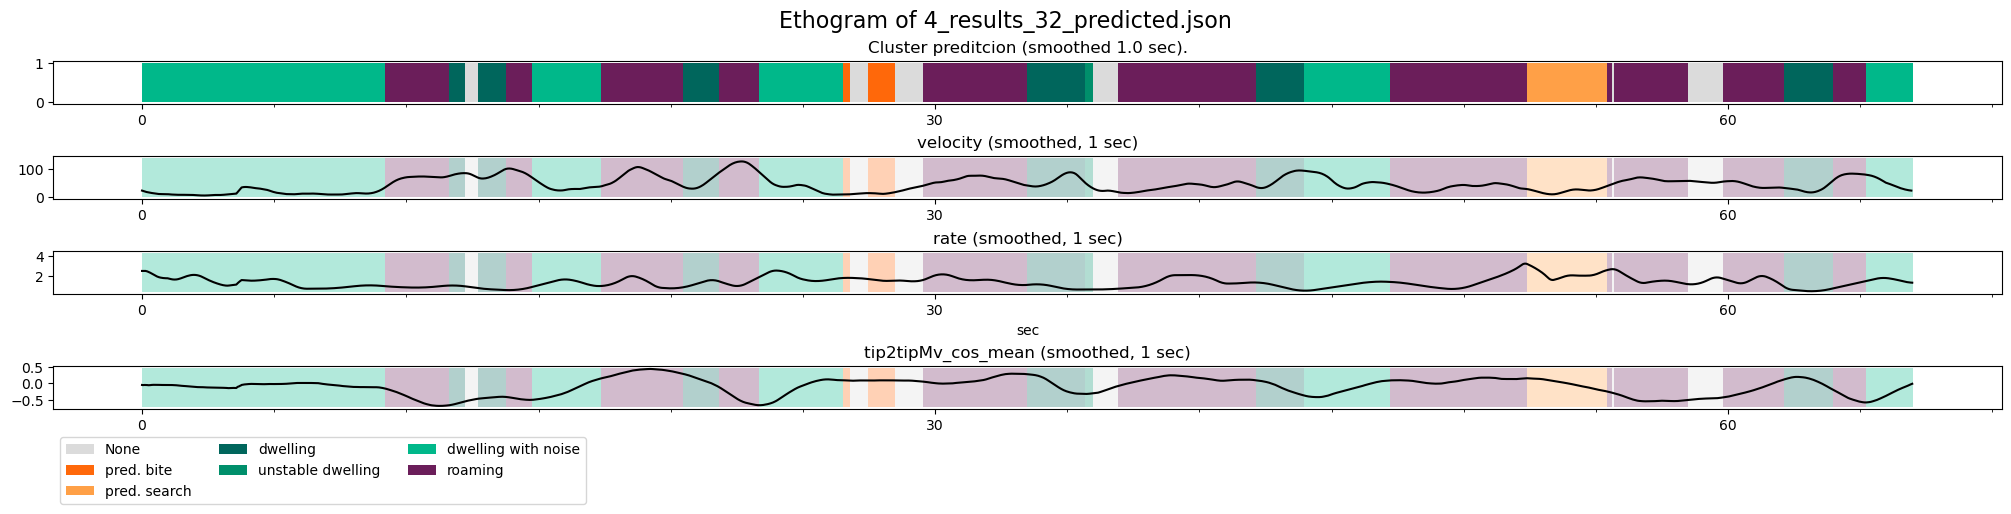

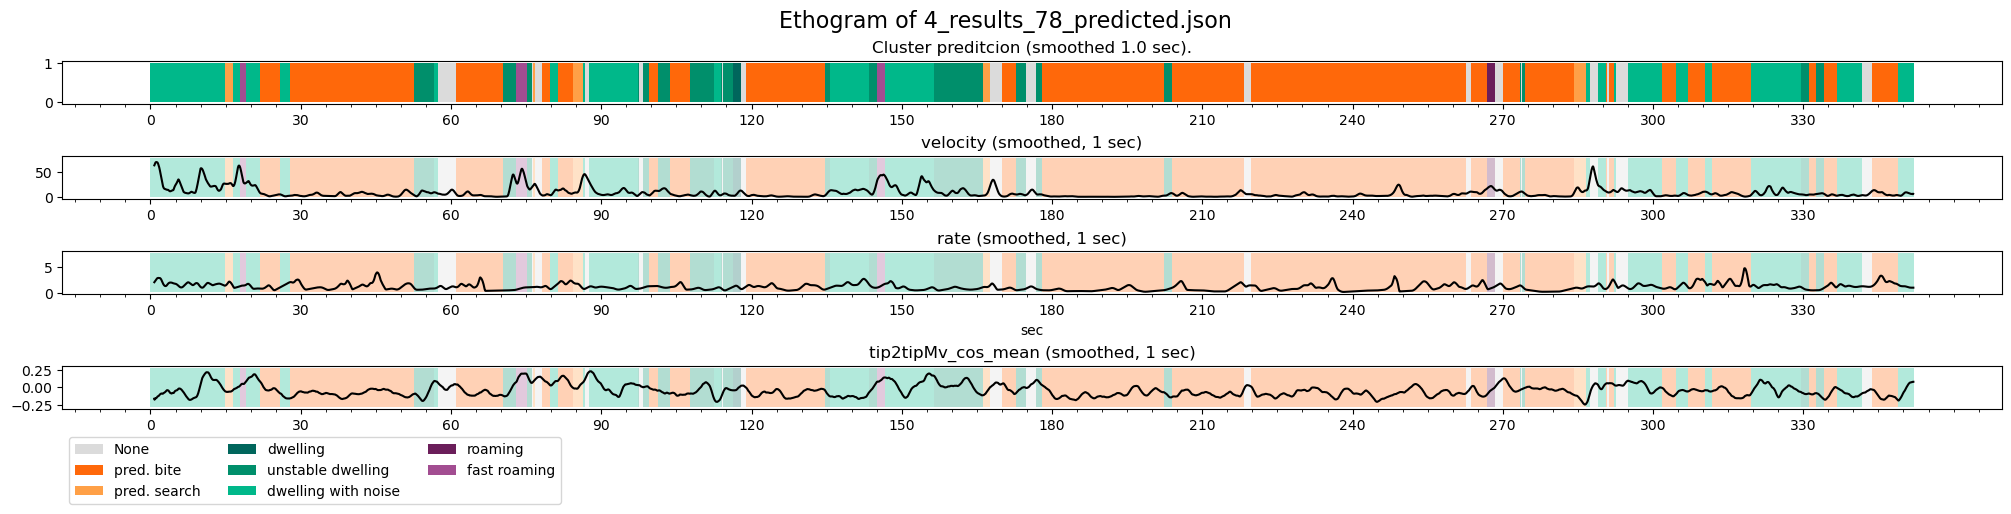

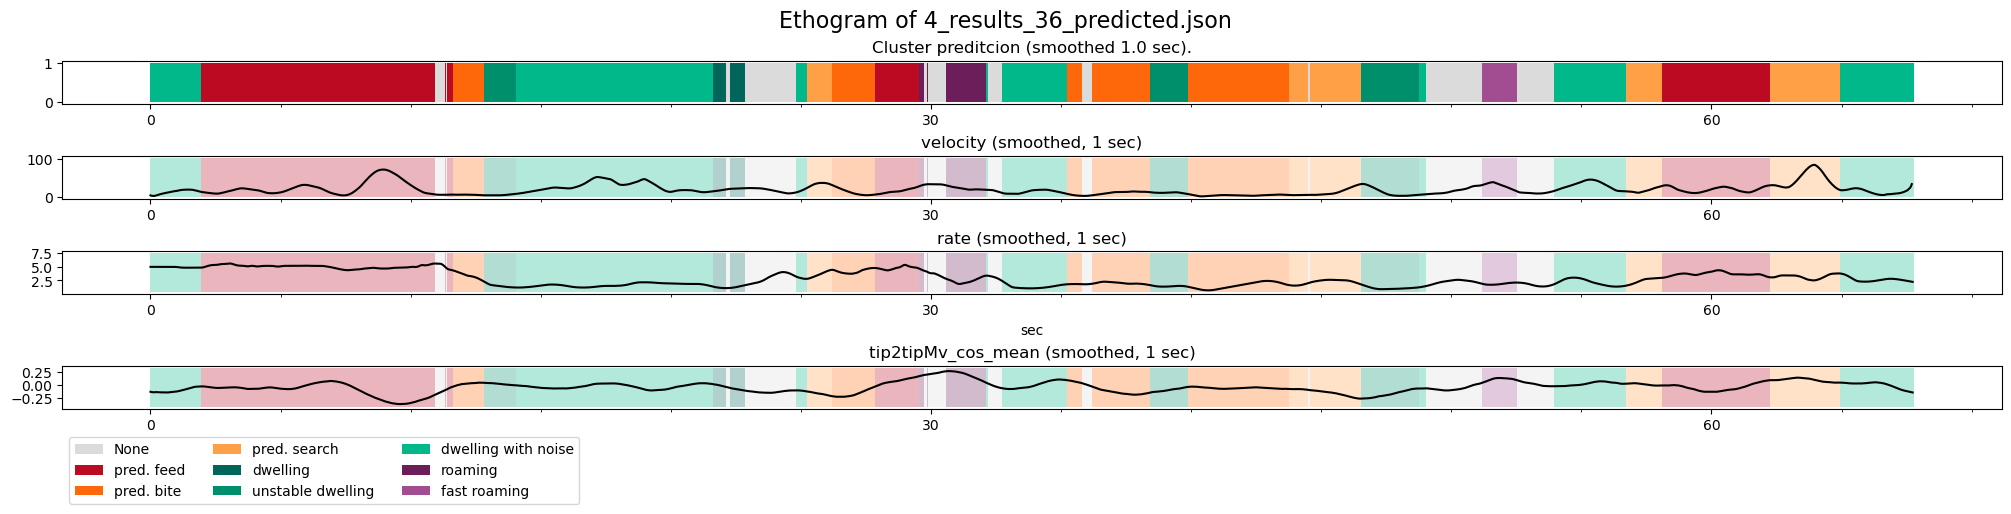

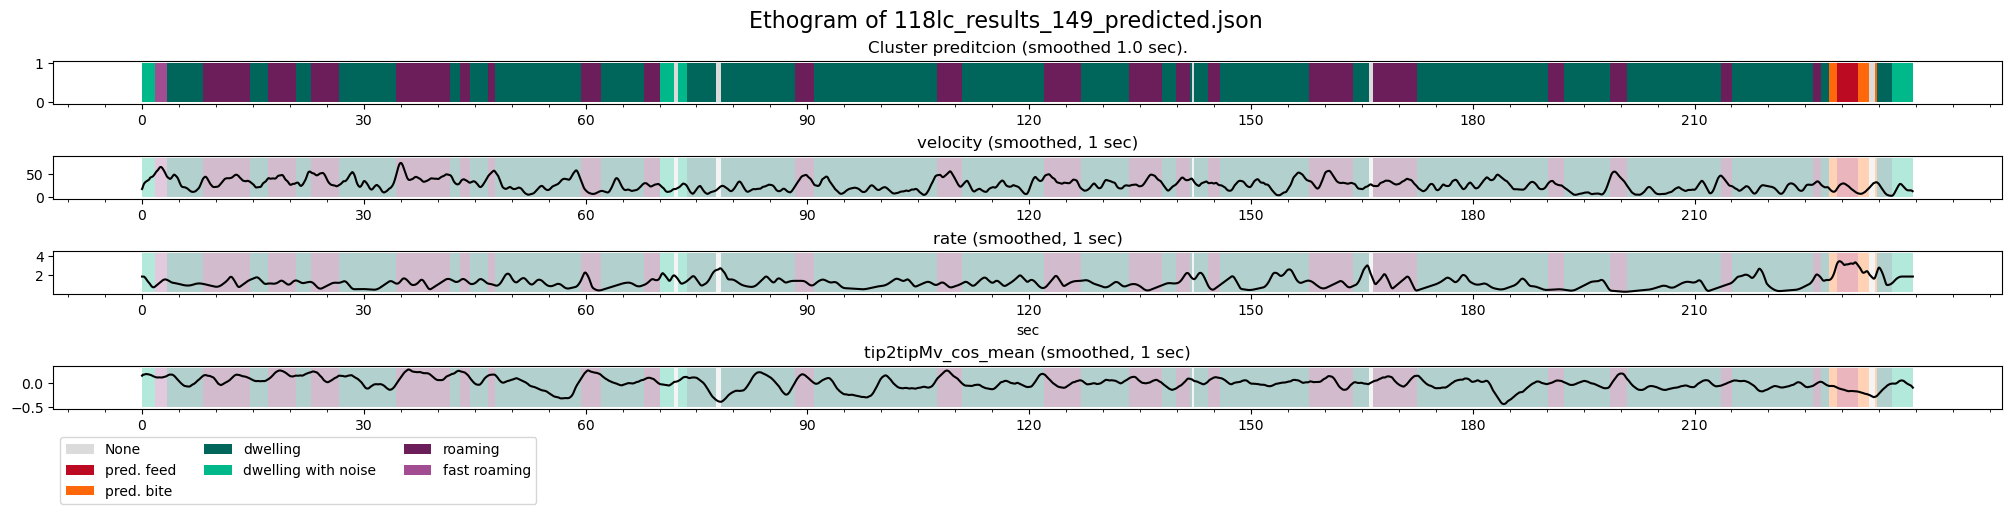

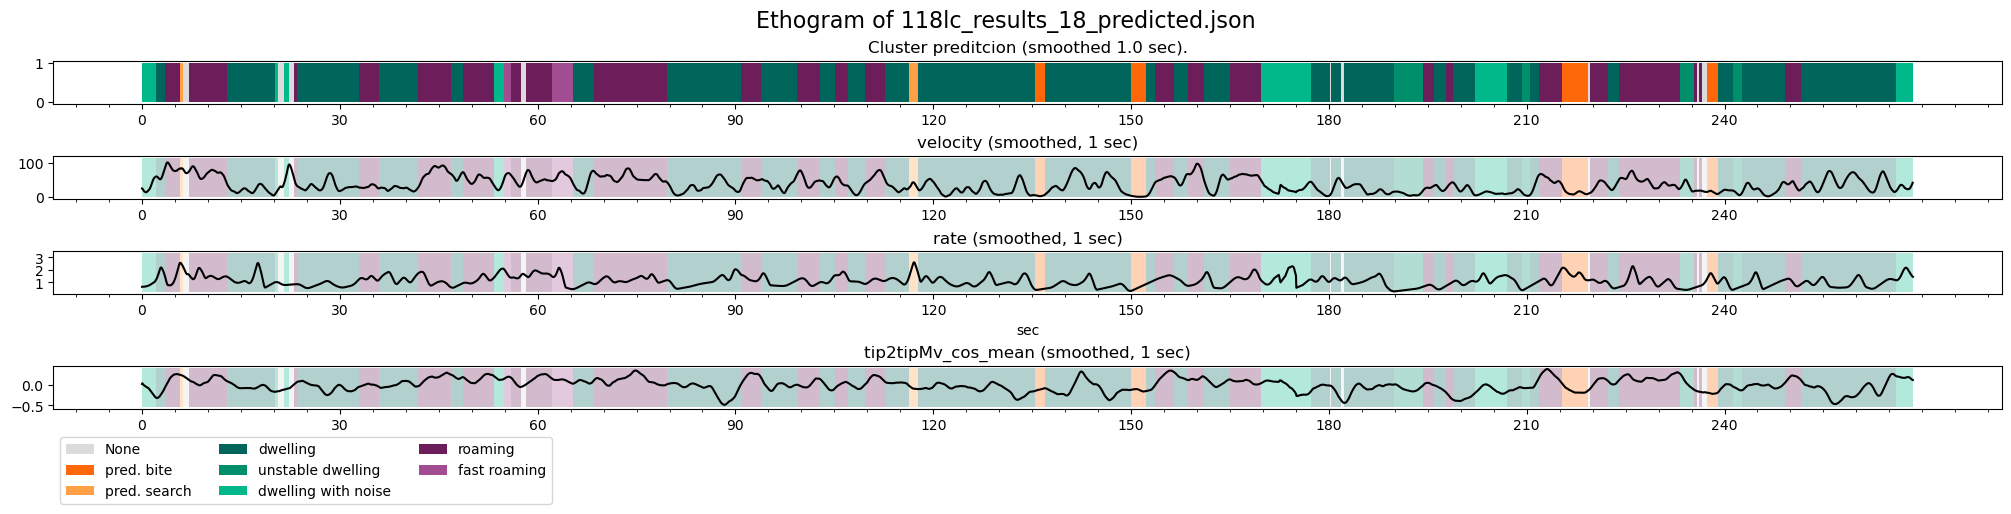

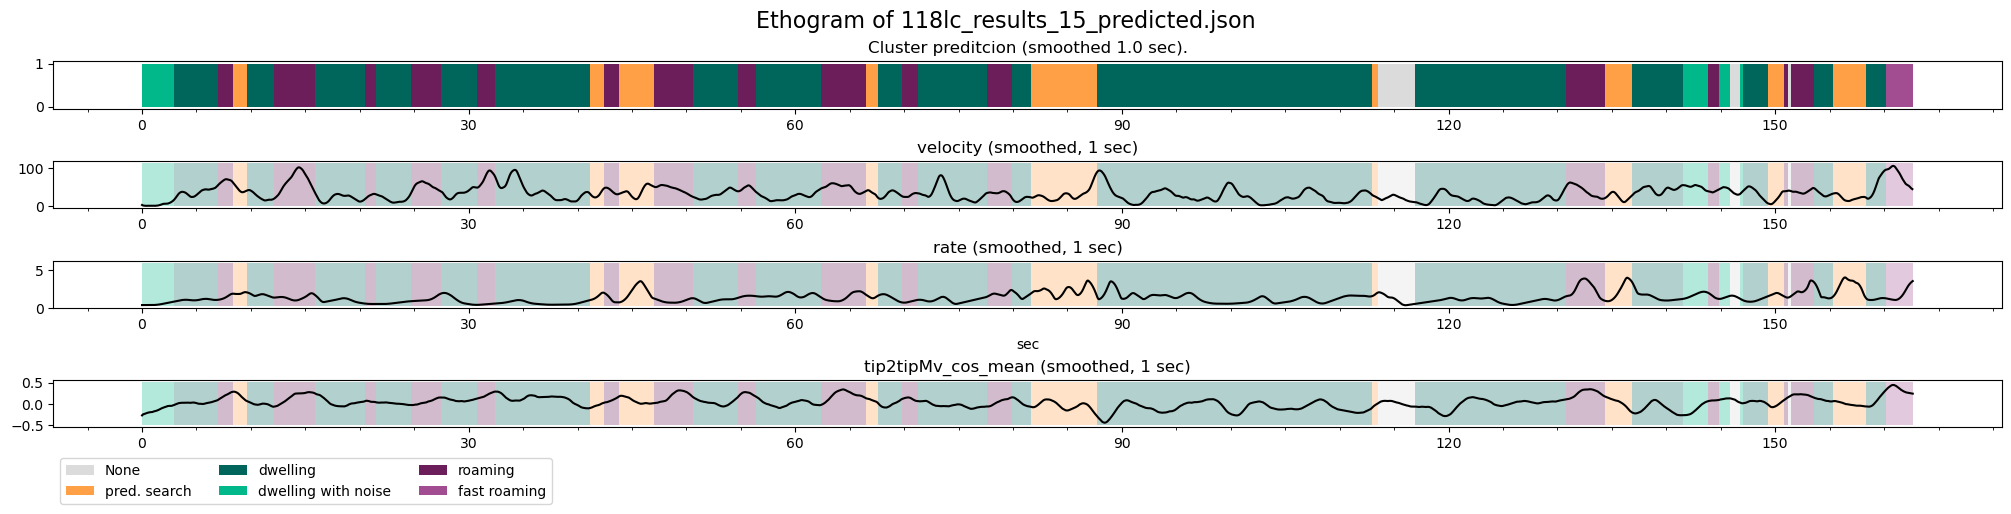

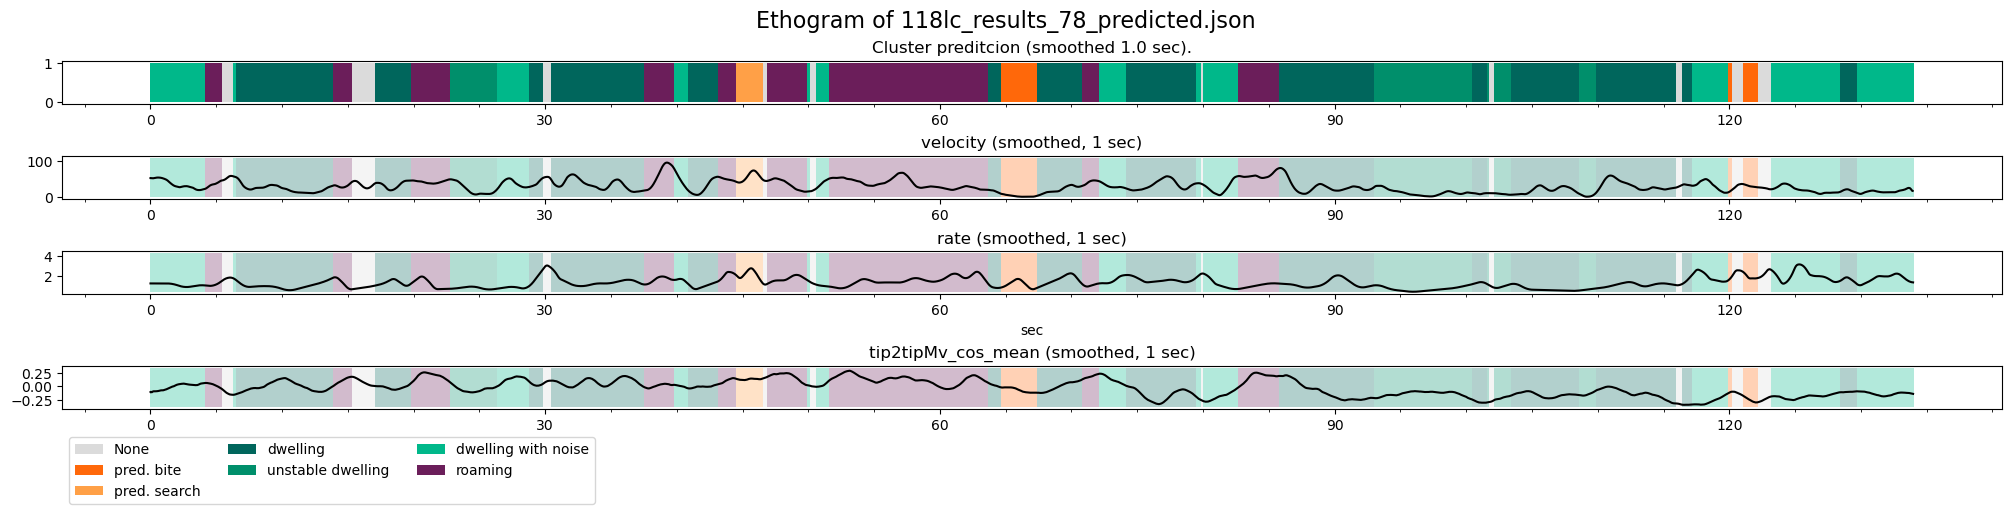

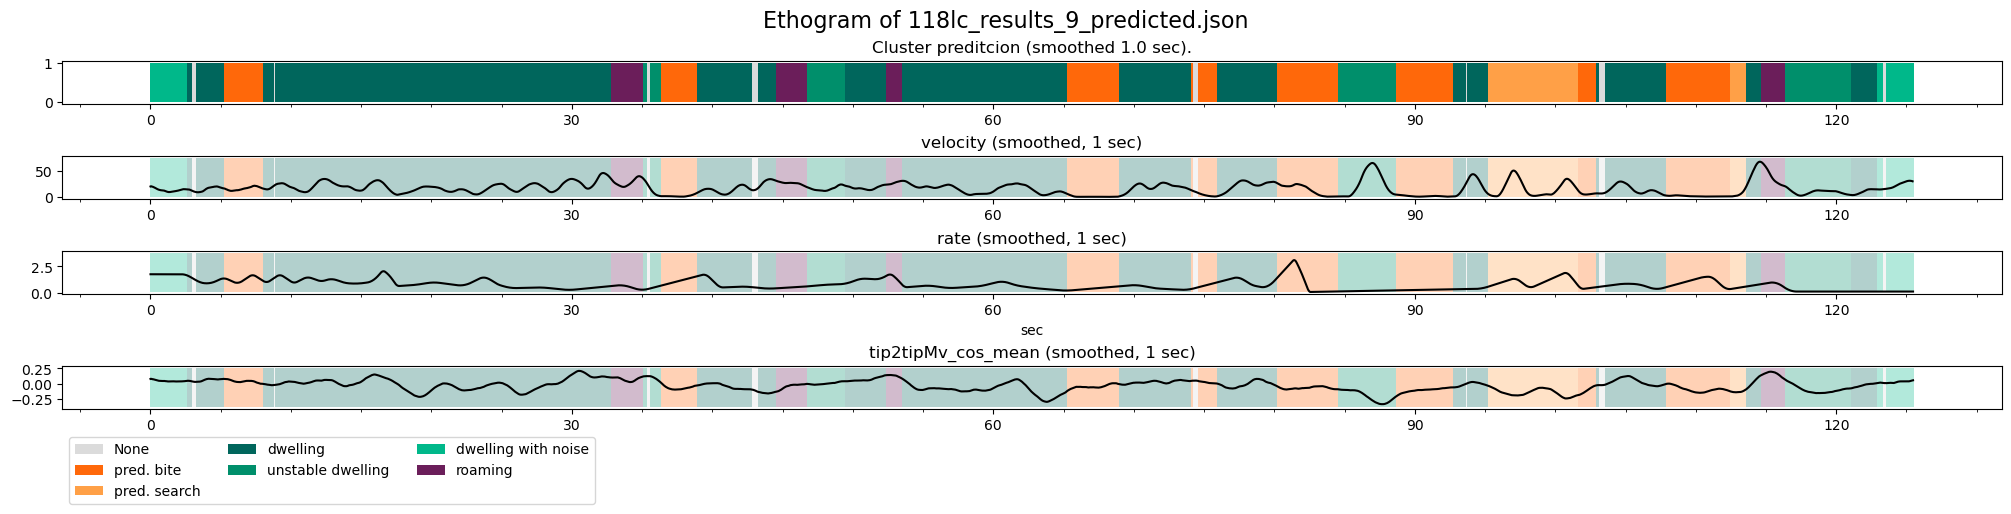

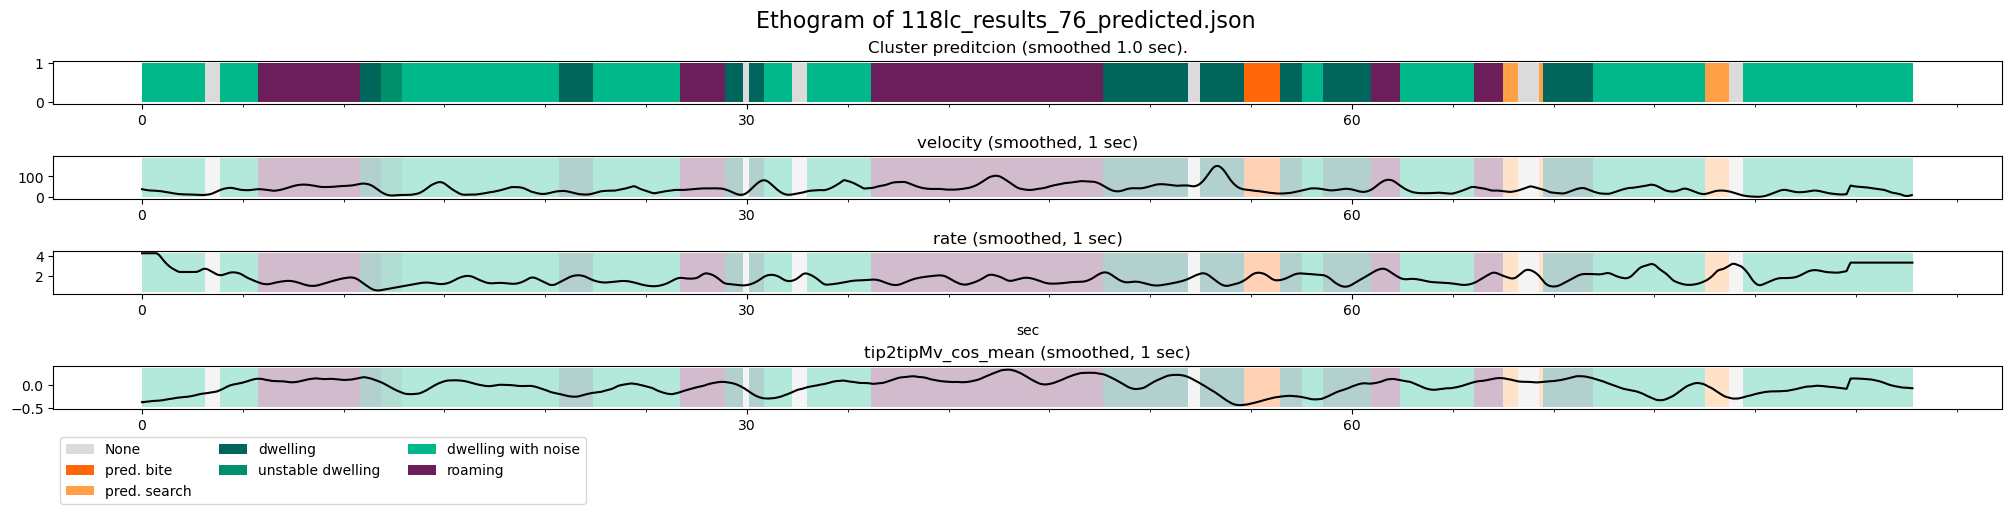

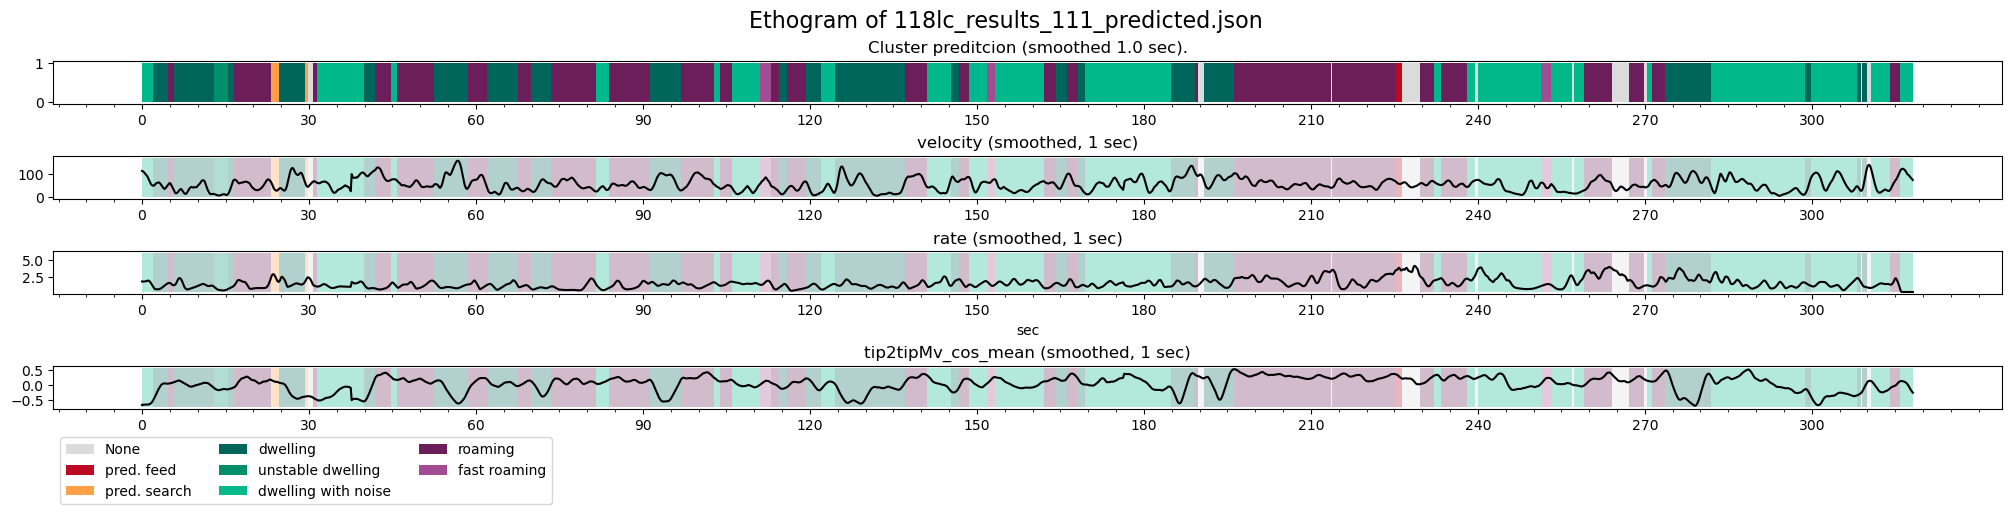

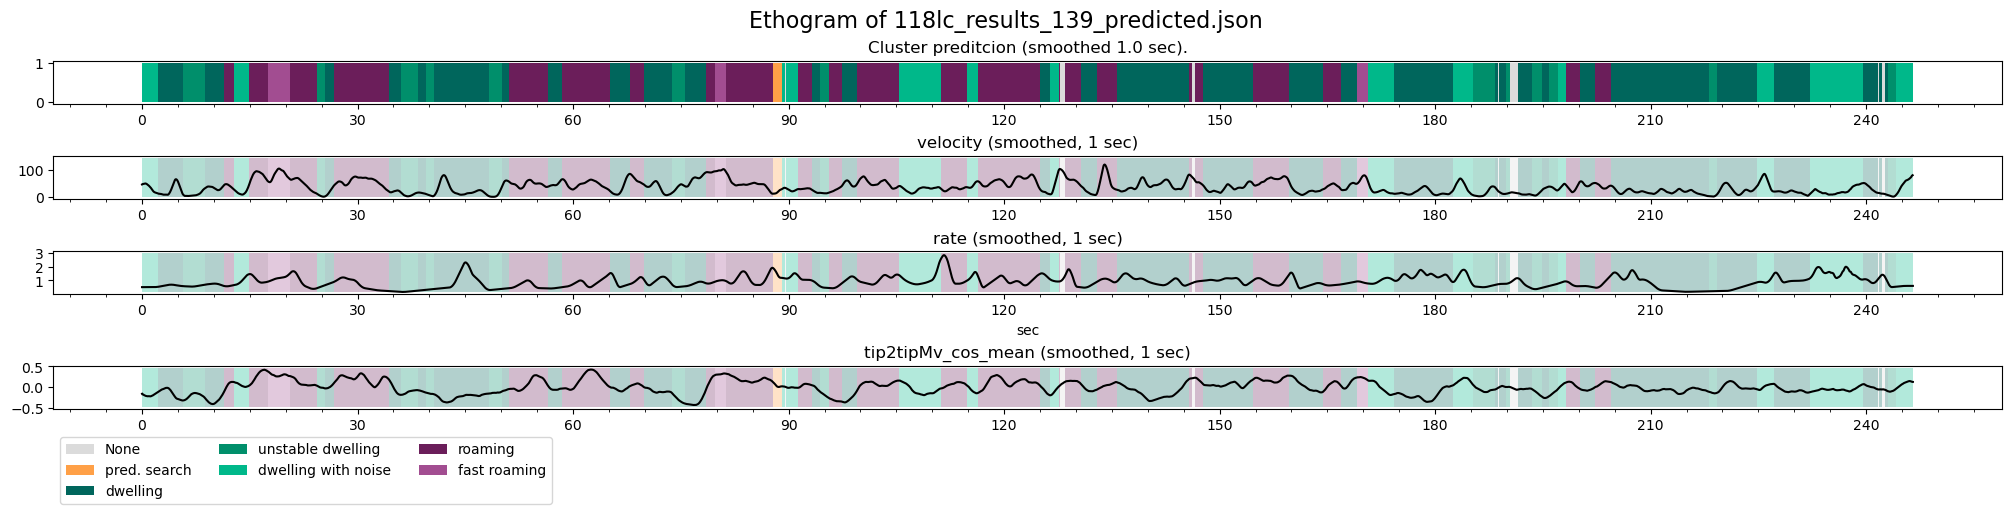

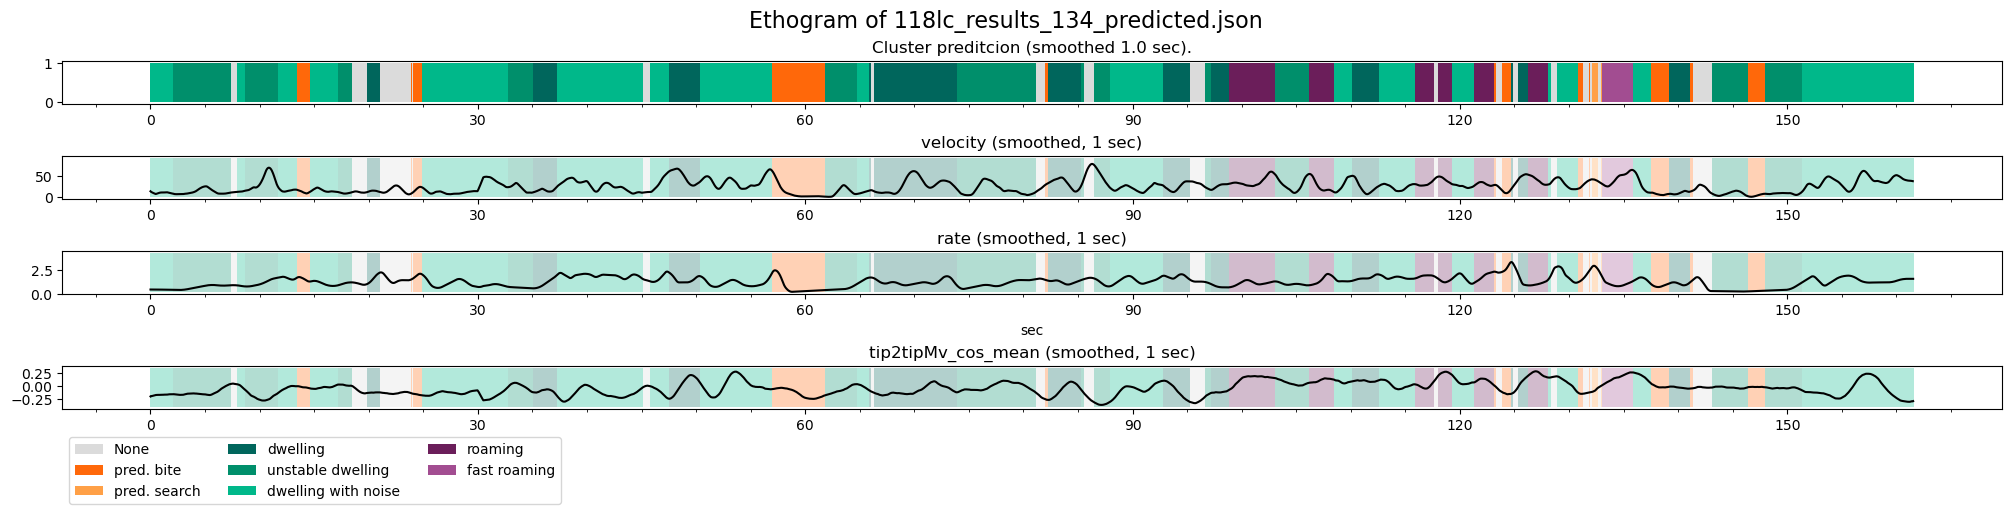

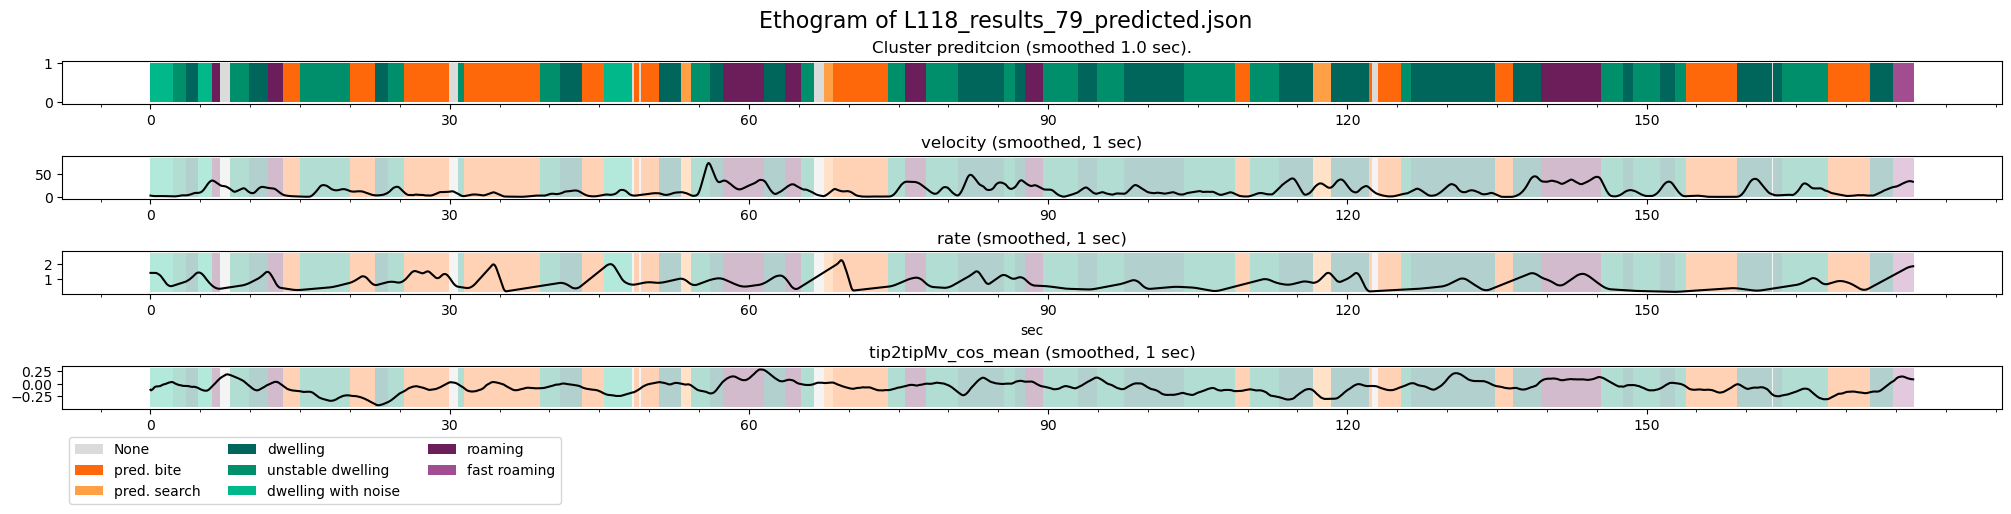

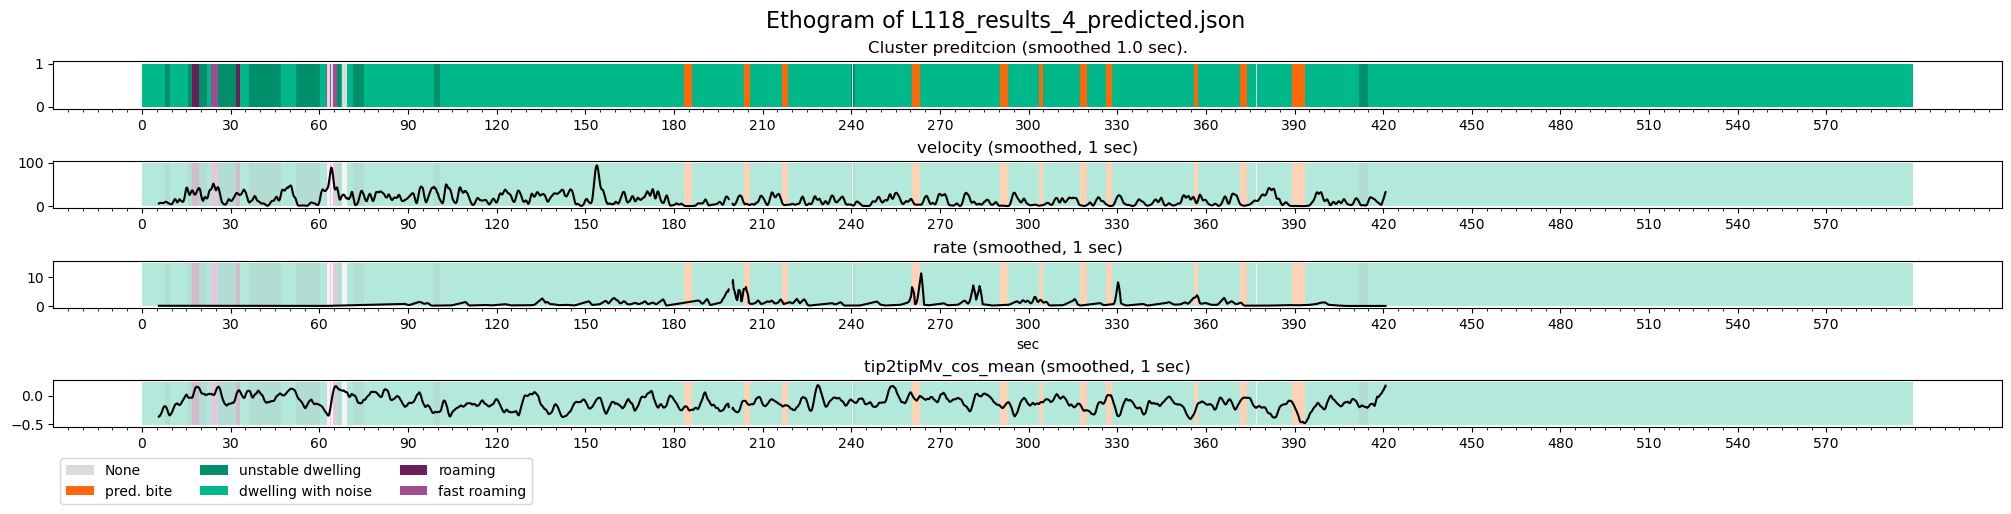

In [105]:
for f_idx in range(0,80,5):
    file = pd.read_json(fpath[f_idx], orient='split')
    fn = os.path.basename(fpath[f_idx])
    onoff = onoff_dict(file['prediction'], labels =np.unique(file['prediction']))
    onoff = {int(k):v for k,v in onoff.items()}
    ethogram_plot = ethogram_plotter(file, file['prediction'], onoff, 30, cluster_color, cluster_group_man, fn = fn, d_toplot=['velocity', 'rate','tip2tipMv_cos_mean'])
    plt.show()

In [92]:
file.columns

Index(['area', 'velocity', 'rate', 'negskew_clean', 'Curvature', 'Length',
       'reversal_rate', 'reversal_fract', 'area_cwt03', 'area_cwt08',
       ...
       'tip2tipMv_sin_mean', 'prediction', 'proba_0', 'proba_1', 'proba_2',
       'proba_3', 'proba_4', 'proba_5', 'proba_6', 'proba_7'],
      dtype='object', length=158)

In [77]:
fpath

{'L118_results_5_predicted.json': '/gpfs/soma_fs/scratch/src/boeger/data_roca/L118_231030/L118_231030_predicted/L118_results_5_predicted.json',
 'L118_results_1_predicted.json': '/gpfs/soma_fs/scratch/src/boeger/data_roca/L118_231030/L118_231030_predicted/L118_results_1_predicted.json',
 '4_results_70_predicted.json': '/gpfs/soma_fs/scratch/src/boeger/data_roca/L118_230905/L118_230905_predicted/4_results_70_predicted.json',
 '4_results_77_predicted.json': '/gpfs/soma_fs/scratch/src/boeger/data_roca/L118_230905/L118_230905_predicted/4_results_77_predicted.json',
 '4_results_6_predicted.json': '/gpfs/soma_fs/scratch/src/boeger/data_roca/L118_230905/L118_230905_predicted/4_results_6_predicted.json',
 '4_results_56_predicted.json': '/gpfs/soma_fs/scratch/src/boeger/data_roca/L118_230905/L118_230905_predicted/4_results_56_predicted.json',
 '4_results_25_predicted.json': '/gpfs/soma_fs/scratch/src/boeger/data_roca/L118_230905/L118_230905_predicted/4_results_25_predicted.json',
 '4_results_69